In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os

In [2]:
path_prefix = os.getcwd() + '/simulation-runs'

In [3]:
vcc = 3 # Tensão de alimentaçaõ em V
rx_current = 21.8 / 1000 # Consumo de corrente do rádio em rx em Ampére
tx_current = 19.5 / 1000 # Consumo de corrente do rádio em tx em Ampére
cpu_sleep_current = 5.1/ 1000000 # Consumo de corrente do rádio em sleep (standby) em Ampére
cpu_idle_current = 54.5 / 1000000 # Consumo de corrente do rádio em idle em Ampére

ticks_per_second = 32768 # Um segundo em clocks do nó
powertrace_sample_rate = 10 # Período de envio de mensagens em segundos
Nb = 90 # Número de bytes por mensagem
packet_size_in_bits = 8 * Nb # Tamanho da mensagem em bits

In [4]:
def read_csv_in_folder(folder_path):
  dfs = []
  for filename in os.listdir(folder_path):
    # Se o arquivo é um arquivo CSV
    if filename.endswith('.csv'):
        # Construir o caminho completo para o arquivo
        file_path = os.path.join(folder_path, filename)
        
        # Ler o arquivo CSV e armazenar o DataFrame na lista
        df = pd.read_csv(file_path)
        dfs.append(df)
  return dfs

In [5]:
aloha_duty_cycles = ["1", "3", "5", "10", "20", "30", "40", "50", "60"]
aloha_rdc_dfs = {}

for rdc in aloha_duty_cycles:
  path = path_prefix + "/" + rdc + "-duty-cycle"
  aloha_rdc_dfs[rdc] = read_csv_in_folder(path)

In [6]:
csma_dfs = read_csv_in_folder(path_prefix + "/csma")
aloha_always_on_dfs = read_csv_in_folder(path_prefix + "/aloha-always-on")

In [7]:
def concat_dfs(dfs):
  return pd.concat(dfs, ignore_index=True)

In [8]:
# Concat dfs
aloha_rdc_dfs_concat = {}
for rdc in aloha_duty_cycles:
  aloha_rdc_dfs_concat[rdc] = concat_dfs(aloha_rdc_dfs[rdc])

csma_df_concat = pd.concat(csma_dfs, ignore_index=True)
aloha_always_on_df_concat = pd.concat(aloha_always_on_dfs, ignore_index=True)

In [9]:
# Cálculo do consumo de corrente em Ampére
def calculate_current_consumption(df):
  return (df['cpu'] * cpu_idle_current + df['transmit'] * tx_current + df['listen'] * rx_current + df['lpm'] * cpu_sleep_current) / ticks_per_second

In [10]:
#Cálculo de potência de cada linha
for rdc in aloha_duty_cycles:
  aloha_rdc_dfs_concat[rdc]['I'] = calculate_current_consumption(aloha_rdc_dfs_concat[rdc])
  aloha_rdc_dfs_concat[rdc]['P0'] = aloha_rdc_dfs_concat[rdc]['I'] * vcc / powertrace_sample_rate # Potência em W
  aloha_rdc_dfs_concat[rdc]['Eihop'] = aloha_rdc_dfs_concat[rdc]['P0'] # Energia em J
  aloha_rdc_dfs_concat[rdc]['Eihop/bit'] = aloha_rdc_dfs_concat[rdc]['Eihop'] / packet_size_in_bits # Energia por bit em J/bit

csma_df_concat['I'] = calculate_current_consumption(csma_df_concat)
csma_df_concat['P0'] = csma_df_concat['I'] * vcc / powertrace_sample_rate # Potência em W
csma_df_concat['Eihop'] = csma_df_concat['P0'] # Energia em J
csma_df_concat['Eihop/bit'] = csma_df_concat['Eihop'] / packet_size_in_bits # Energia por bit em J/bit

aloha_always_on_df_concat['I'] = calculate_current_consumption(aloha_always_on_df_concat)
aloha_always_on_df_concat['P0'] = aloha_always_on_df_concat['I'] * vcc / powertrace_sample_rate # Potência em W
aloha_always_on_df_concat['Eihop'] = aloha_always_on_df_concat['P0'] # Energia em J
aloha_always_on_df_concat['Eihop/bit'] = aloha_always_on_df_concat['Eihop'] / packet_size_in_bits # Energia por bit em J/bit

In [11]:
columns_to_drop = ['cpu', 'transmit', 'listen', 'lpm']
aloha_rdc_final_dfs = {}
for rdc in aloha_duty_cycles:
  aloha_rdc_final_dfs[rdc] = aloha_rdc_dfs_concat[rdc].drop(columns=columns_to_drop)

csma_df_final = csma_df_concat.drop(columns=columns_to_drop)
aloha_always_on_df_final = aloha_always_on_df_concat.drop(columns=columns_to_drop)

In [12]:
# For 95% confidence interval when n = 10 (11 samples)
z = 2.228
n = 11

In [13]:
def plot_error_bar(ax, mean, margin_of_error, title, x_label, y_label):
  ax.errorbar(0, mean, yerr=margin_of_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

In [14]:
def calculate_mean_and_margin_of_error(data):
  mean = data.mean()
  std = data.std()
  margin_of_error = z * (std / np.sqrt(n))
  return mean, margin_of_error

In [15]:
aloha_mean_and_margin_of_error = {}
for rdc in aloha_duty_cycles:
  aloha_mean_and_margin_of_error[rdc] = calculate_mean_and_margin_of_error(aloha_rdc_final_dfs[rdc]['Eihop'])

csma_mean_and_margin_of_error = calculate_mean_and_margin_of_error(csma_df_final['Eihop'])
aloha_always_on_mean_and_margin_of_error = calculate_mean_and_margin_of_error(aloha_always_on_df_final['Eihop'])

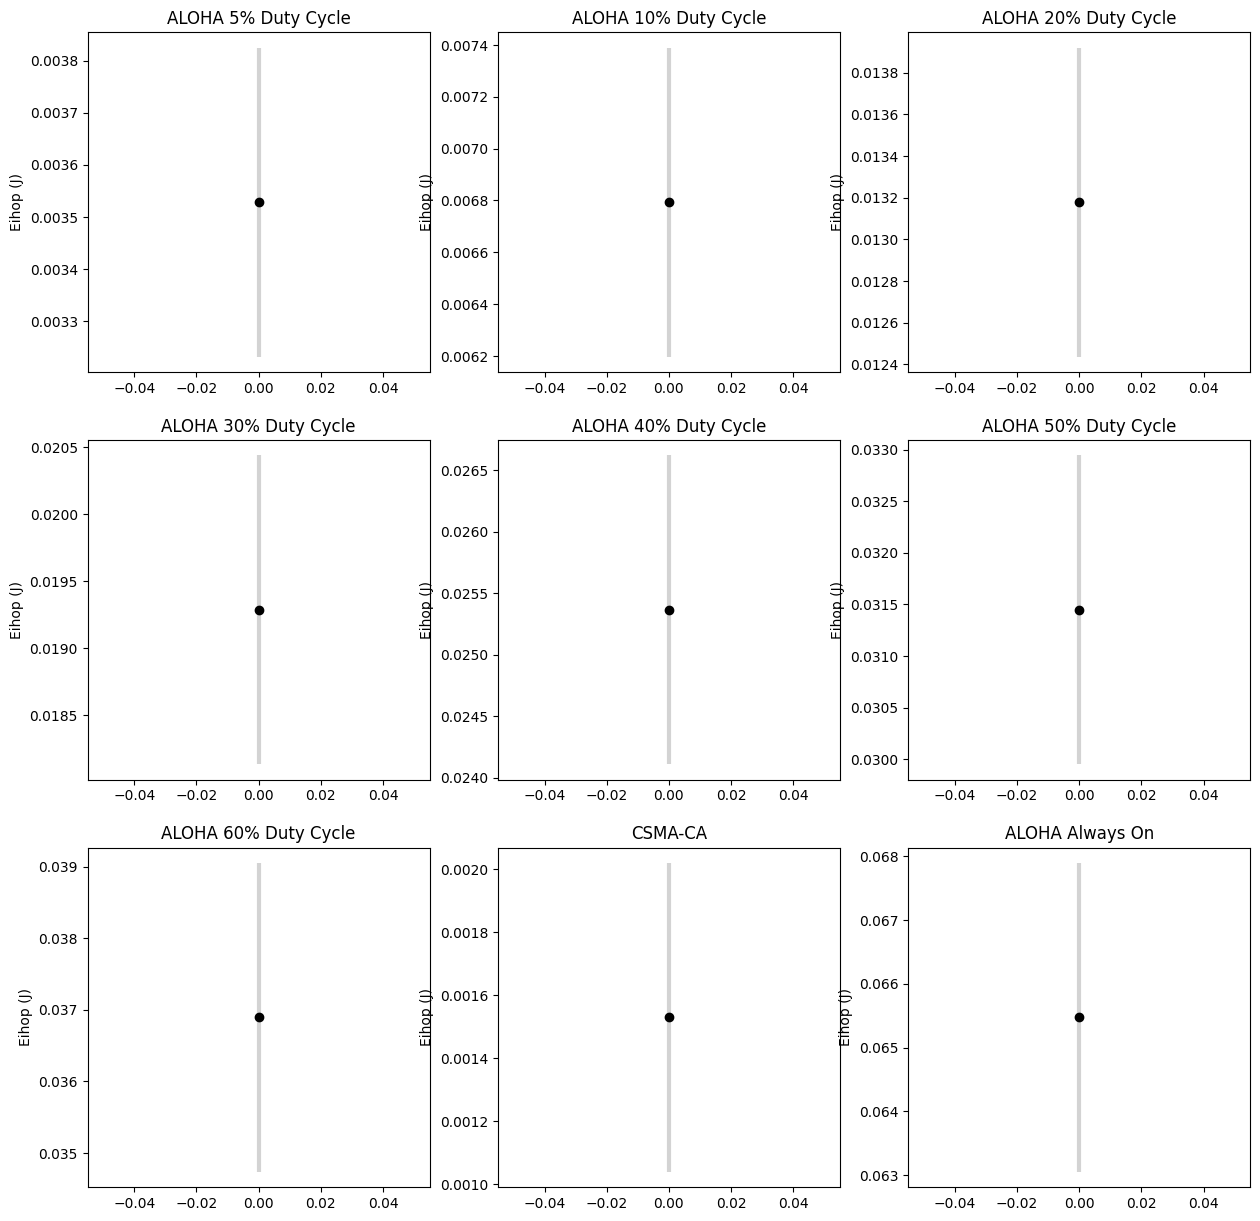

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plot_error_bar(axs[0,0], aloha_mean_and_margin_of_error["5"][0], aloha_mean_and_margin_of_error["5"][1], 'ALOHA 5% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[0,1], aloha_mean_and_margin_of_error["10"][0], aloha_mean_and_margin_of_error["10"][1], 'ALOHA 10% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[0,2], aloha_mean_and_margin_of_error["20"][0], aloha_mean_and_margin_of_error["20"][1], 'ALOHA 20% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[1,0], aloha_mean_and_margin_of_error["30"][0], aloha_mean_and_margin_of_error["30"][1], 'ALOHA 30% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[1,1], aloha_mean_and_margin_of_error["40"][0], aloha_mean_and_margin_of_error["40"][1], 'ALOHA 40% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[1,2], aloha_mean_and_margin_of_error["50"][0], aloha_mean_and_margin_of_error["50"][1], 'ALOHA 50% Duty Cycle', '', 'Eihop (J)')
plot_error_bar(axs[2,0], aloha_mean_and_margin_of_error["60"][0], aloha_mean_and_margin_of_error["60"][1], 'ALOHA 60% Duty Cycle', '', 'Eihop (J)')

plot_error_bar(axs[2,1], csma_mean_and_margin_of_error[0], csma_mean_and_margin_of_error[1], 'CSMA-CA', '', 'Eihop (J)')
plot_error_bar(axs[2,2], aloha_always_on_mean_and_margin_of_error[0], aloha_always_on_mean_and_margin_of_error[1], 'ALOHA Always On', '', 'Eihop (J)')

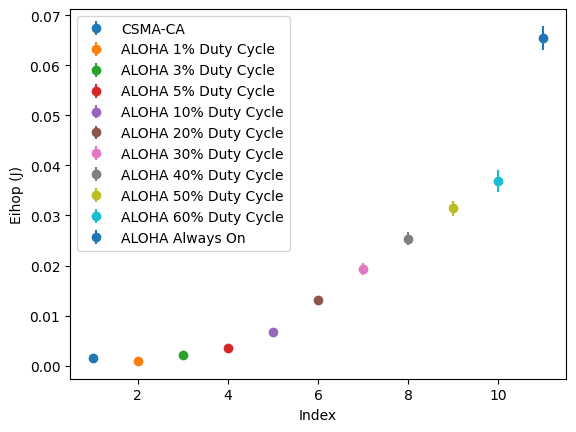

In [17]:
def plot_error_bar(x, mean, margin_of_error, label):
    plt.errorbar(x, mean, yerr=margin_of_error, fmt='o', label=label)

# Dados para plotar

aloha_labels = [f'ALOHA {dc}% Duty Cycle' for dc in aloha_duty_cycles]
csma_label = 'CSMA-CA'
aloha_always_on_label = 'ALOHA Always On'

# Plotar os gráficos
x = 1
plot_error_bar(x, csma_mean_and_margin_of_error[0], csma_mean_and_margin_of_error[1], csma_label)
for dc, label in zip(aloha_duty_cycles, aloha_labels):
    x += 1
    plot_error_bar(x, aloha_mean_and_margin_of_error[dc][0], aloha_mean_and_margin_of_error[dc][1], label)
plot_error_bar(x + 1, aloha_always_on_mean_and_margin_of_error[0], aloha_always_on_mean_and_margin_of_error[1], aloha_always_on_label)

# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel('Eihop (J)')

# Mostrar o gráfico
plt.show()

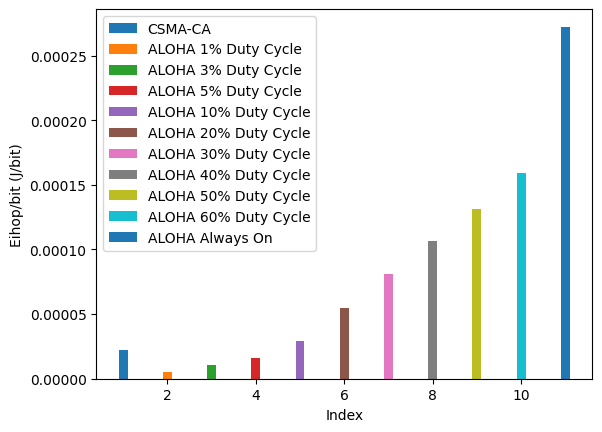

In [27]:
#Plot energy per bit
def plot_energy_per_bit(x, data, label):
    plt.bar(x, data, 0.2, label=label)

aloha_labels = [f'ALOHA {dc}% Duty Cycle' for dc in aloha_duty_cycles]
csma_label = 'CSMA-CA'
aloha_always_on_label = 'ALOHA Always On'

# Plotar os gráficos
x = 1
plot_energy_per_bit(x, csma_df_final['Eihop/bit'], csma_label)
for dc, label in zip(aloha_duty_cycles, aloha_labels):
    x += 1
    plot_energy_per_bit(x, aloha_rdc_final_dfs[dc]['Eihop/bit'], label)
plot_energy_per_bit(x + 1, aloha_always_on_df_final['Eihop/bit'],  aloha_always_on_label)


# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel('Eihop/bit (J/bit)')

# Mostrar o gráfico
plt.show()


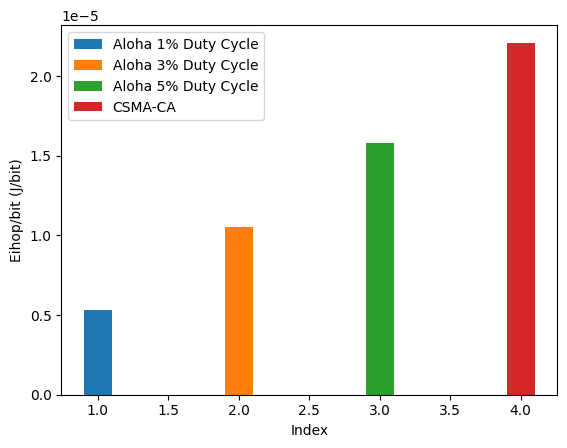

In [19]:
plot_energy_per_bit(1, aloha_rdc_final_dfs['1']['Eihop/bit'], 'Aloha 1% Duty Cycle')
plot_energy_per_bit(2, aloha_rdc_final_dfs['3']['Eihop/bit'], 'Aloha 3% Duty Cycle')
plot_energy_per_bit(3, aloha_rdc_final_dfs['5']['Eihop/bit'], 'Aloha 5% Duty Cycle')
plot_energy_per_bit(4, csma_df_final['Eihop/bit'], csma_label)

plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel('Eihop/bit (J/bit)')

# Mostrar o gráfico
plt.show()

In [24]:
print('ALOHA 1% Duty Cycle - count: ' + str(len(aloha_rdc_final_dfs['1'])))
print('ALOHA 3% Duty Cycle - count: ' + str(len(aloha_rdc_final_dfs['3'])))
print('ALOHA 5% Duty Cycle - count: ' + str(len(aloha_rdc_final_dfs['5'])))
print('CSMA - count: ' + str(len(csma_df_final)))

ALOHA 1% Duty Cycle - count: 371
ALOHA 3% Duty Cycle - count: 1427
ALOHA 5% Duty Cycle - count: 2205
CSMA - count: 15770
